(1000, 2)
ODENet Training
Epoch: 10, Loss: 0.1489830416614326
Epoch: 20, Loss: 0.022555730719386248
Epoch: 30, Loss: 0.0066729672111067945
Epoch: 40, Loss: 0.0009397589884115142
Epoch: 50, Loss: 0.0013925343521619254
Epoch: 60, Loss: 0.0001759536880024067
Epoch: 70, Loss: 0.0001251753389048126
Epoch: 80, Loss: 0.0003280782051052107
Epoch: 90, Loss: 0.0016937163323724005
Epoch: 100, Loss: 4.769458151313721e-05
Epoch: 110, Loss: 4.089464078305976e-05
Epoch: 120, Loss: 3.9882661256848176e-05
Epoch: 130, Loss: 8.127276601688076e-05
Epoch: 140, Loss: 3.975429609303847e-05
Epoch: 150, Loss: 0.0005042700778868345
Epoch: 160, Loss: 0.0006561078138988762
Epoch: 170, Loss: 3.038916181199579e-05
Epoch: 180, Loss: 0.001936176529495648
Epoch: 190, Loss: 2.8563017278168345e-05
Epoch: 200, Loss: 3.0924533744350486e-05
Epoch: 210, Loss: 2.5463956027911943e-05
Epoch: 220, Loss: 0.013517445982781913
Epoch: 230, Loss: 3.569639762653264e-05
Epoch: 240, Loss: 0.00014145734706990244
Epoch: 250, Loss: 0.0002

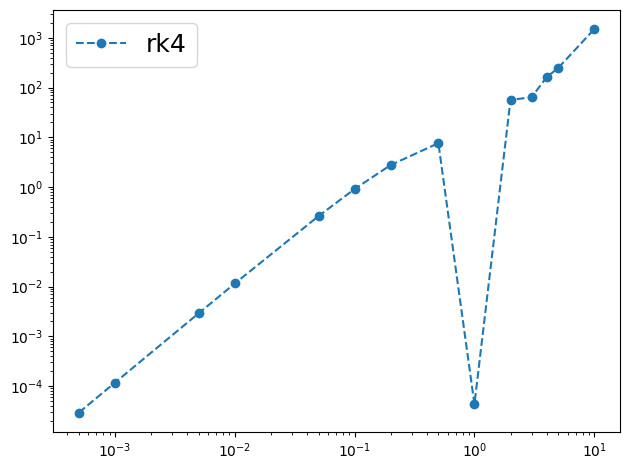

In [ ]:
import numpy as np
import scipy as sci

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

import torch
import torch.optim as optim

from scipy.special import ellipj, ellipk

BATCH_SIZE = 50
WEIGHT_DECAY = 0
LEARNING_RATE = 1e-3 #5e-3
NUMBER_EPOCHS = 3000



def set_seed(seed=3):
    """Set one seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def create_data(tmax=20, dt=1, theta0=1.6):
    """Solution for the nonlinear pendulum in theta space."""
    t = np.arange(0, tmax, dt)
    S = np.sin(0.5*(theta0) )
    K_S = ellipk(S**2)
    omega_0 = np.sqrt(9.81)
    sn,cn,dn,ph = ellipj( K_S - omega_0*t, S**2 )
    theta = 2.0*np.arcsin( S*sn )
    d_sn_du = cn*dn
    d_sn_dt = -omega_0 * d_sn_du
    d_theta_dt = 2.0*S*d_sn_dt / np.sqrt(1.0-(S*sn)**2)
    return np.stack([theta, d_theta_dt], axis=1)


def create_dataloader(x, batch_size=BATCH_SIZE):
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(np.asarray(x[0:-1]), dtype=torch.double),
        torch.tensor(np.asarray(x[1::]), dtype=torch.double),
    )

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

    dataset = torch.utils.data.TensorDataset(
        torch.tensor(np.asarray(x[0:-1]), dtype=torch.double),
        torch.tensor(np.asarray(x[1::]), dtype=torch.double),
    )

    test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, test_loader



def euler_step_func(f, x, dt):
    """The 'forward' Euler, a one stage Runge Kutta."""
    k1 = f(x)
    x_out = x + dt * k1
    return x_out

def rk4_step_func(f, x, dt):
    """The 'classic' RK4, a four stage Runge Kutta, O(Dt^4)."""
    k1 = f(x)
    x1 = x + 0.5 * dt * k1
    k2 = f(x1)
    x2 = x + 0.5 * dt * k2
    k3 = f(x2)
    x3 = x + dt * k3
    k4 = f(x3)
    x_out = x + dt * (1.0 / 6.0 * k1 + 1.0 / 3.0 * k2 + 1.0 / 3.0 * k3 +
                      1.0 / 6.0 * k4)
    return x_out


def shallow(in_dim, hidden, out_dim, Act=torch.nn.Tanh):
    """Just make a shallow network. This is more of a macro."""
    return torch.nn.Sequential(
        torch.nn.Linear(in_dim, hidden),
        Act(),
        torch.nn.Linear(hidden, out_dim), )


class ShallowODE(torch.nn.Module):
    """A basic shallow network that takes in a t as well"""

    def __init__(self, in_dim, out_dim, hidden=10, Act=torch.nn.Tanh):
        super(ShallowODE, self).__init__()
        self.net = shallow(in_dim, hidden, out_dim, Act=Act)

    def forward(self, x, h, dt, method='euler'):
        if method=='euler':
            #print(method)
            #for i in range(int(dt/h)):
            x = euler_step_func(self.net, x, dt)
            return x
        elif method=='rk4':
            #print(method)
            #for i in range(int(dt/h)):
            x = rk4_step_func(self.net, x, dt)
            return x


def train(ODEnet, train_loader, lr=LEARNING_RATE, wd=WEIGHT_DECAY, method='rk4', dt=0.1):

    optimizer_ODEnet = optim.Adam(ODEnet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    criterion = torch.nn.MSELoss()

    ode_loss_hist = []
    print('ODENet Training')
    for epoch in range(1, NUMBER_EPOCHS):
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer_ODEnet.zero_grad()
            outputs = ODEnet(inputs, h=dt, dt=dt, method=method)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer_ODEnet.step()
            ode_loss_hist.append(loss.item())

        if epoch % 10 == 0: print(f'Epoch: {epoch}, Loss: {loss.item()}')

    return ODEnet, ode_loss_hist



# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    dt = 0.2
    N_points = 1000
    T_MAX = N_points * dt
    x = create_data(tmax=T_MAX, dt=dt)
    print(x.shape)
    #fig = plt.figure()
    #plt.plot(x, 'o--')

    train_loader, test_loader = create_dataloader(x)
    integrator = 'rk4'
    hidden = 200

    set_seed(1)
    ODEnet = ShallowODE(in_dim=2, hidden=hidden, out_dim=2, Act=torch.nn.Tanh).double()
    ODEnet, ode_loss_hist = train(ODEnet, train_loader, method=integrator, dt=dt)

    error = []

    # Evaluate the model --
    hs = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 10]

    for h in hs:
        T_MAX = N_points * dt
        x = create_data(tmax=T_MAX, dt=h)
        _, test_loader = create_dataloader(x)

        target_list = []
        output_list = []
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = ODEnet(inputs, h=h, dt=h, method=integrator)
            output_list.append(outputs.detach().numpy())
            target_list.append(targets.numpy())

        error.append(np.mean(np.linalg.norm(np.vstack(output_list)-np.vstack(target_list), axis=1)**2))

    error = np.vstack(error)

    #fig = plt.figure()
    plt.plot(hs, error, 'o--', label=integrator)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(fontsize=18)
    plt.tight_layout()

